# Intro
This notebook is used to showcases which precautions to take to ensure you can iteratively develop Neural Networks and get reproducible results. Specifically for the case where you go back and forth between preprocessing and training cells, experimenting with differnt settings. For the complete write-up and explanation, please read my blogpost [here](https://medium.com/r/?url=https%3A%2F%2Ftowardsdatascience.com%2Ftagged%2Fexploring-nasa-turbofan)

In [1]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

## step 1: set random seeds to get reproducible results

Initial weights of neural networks are generated randomly. Due to this randomness, results may vary across training cycles, making it very difficult to judge whether the changes in model performance are because of this randomness or actuall improvements. Therefore we wan't to control the random initialization to allow comparing between iterations.


In [3]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
dir_path = './CMAPSSData/'
train_file = 'train_FD001.txt'
test_file = 'test_FD001.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [5]:
print(train.shape)
train.head()

(20631, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


# Modelling

In [7]:
X_train = train[sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop(['time_cycles']+setting_names, axis=1).groupby('unit_nr').last().copy()  # get the last row of each engine

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)

In [9]:
# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [10]:
train_cols = sensor_names  # + setting_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [11]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('reproducible_primer_weights.h5')  # important, weights are saved after compiling the model

## Step 2: save model weights for later reuse
After training a model the first time, you want to be able to reset it's state to the original values. This includes the optimizer parameters and the model weights.  
The optimizer is reset by recompining the model, but recompiling generates a new set of random weights (from the seed you've set). Therefore, you need to load the original weights to get reproducible results.

In [12]:
epochs = 20

# reset initial optimizer parameters by recompiling model
# and reset initial model weights to allow repeated running of cell with consistent results
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('reproducible_primer_weights.h5')

history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs)

Train on 16561 samples, validate on 4070 samples
Epoch 1/20
16561/16561 [==============================] - 2s 132us/sample - loss: 2301.6502 - val_loss: 421.9053
Epoch 2/20
16561/16561 [==============================] - 2s 92us/sample - loss: 432.1362 - val_loss: 364.5692
Epoch 3/20
16561/16561 [==============================] - 1s 63us/sample - loss: 397.5807 - val_loss: 329.9561
Epoch 4/20
16561/16561 [==============================] - 1s 57us/sample - loss: 379.3664 - val_loss: 317.8431
Epoch 5/20
16561/16561 [==============================] - 1s 64us/sample - loss: 370.3313 - val_loss: 309.5288
Epoch 6/20
16561/16561 [==============================] - 1s 61us/sample - loss: 364.8850 - val_loss: 303.8538
Epoch 7/20
16561/16561 [==============================] - 1s 58us/sample - loss: 359.3875 - val_loss: 298.7764
Epoch 8/20
16561/16561 [==============================] - 1s 59us/sample - loss: 356.1165 - val_loss: 299.1210
Epoch 9/20
16561/16561 [==============================] - 1s 

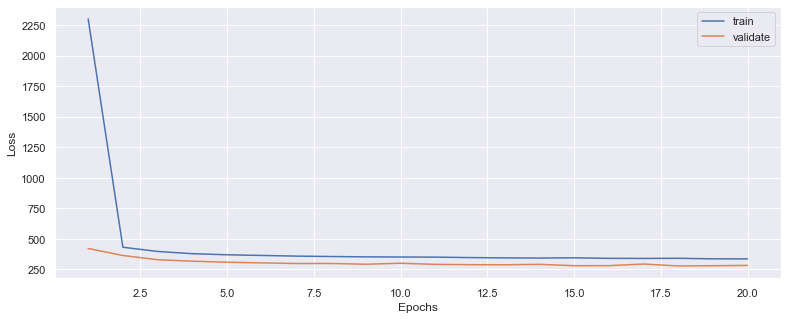

In [13]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [14]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [15]:
# predict and evaluate
y_hat_train = model.predict(X_train_scaled[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train')

# y_hat_test = model.predict(X_test_scaled[train_cols])
# evaluate(y_test, y_hat_test)

train set RMSE:18.004364211864736, R2:0.813339453755806


# add smoothing

In [16]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

## Step 3:
You can run the cells below with different values of alpha. When you decide to go back and use the initial value of alpha = 0.4, you get the same RMSE from the NN

In [17]:
# prep data
alpha = 0.4

X_train_interim = train[index_names + sensor_names].copy()
X_test_interim = test[index_names + sensor_names].copy()

X_train_interim[sensor_names] = pd.DataFrame(scaler.transform(X_train_interim[sensor_names]), columns=sensor_names)
X_test_interim[sensor_names] = pd.DataFrame(scaler.transform(X_test_interim[sensor_names]), columns=sensor_names)

X_train_interim = exponential_smoothing(X_train_interim, sensor_names, 0, alpha)
X_test_interim = exponential_smoothing(X_test_interim, sensor_names, 0, alpha)

X_train_smooth = X_train_interim.drop(index_names, axis=1)
X_test_smooth = X_test_interim.drop('time_cycles', axis=1).groupby('unit_nr').last().copy()

In [18]:
split_result = train_val_group_split(X_train_smooth, y_train_clipped, gss, train['unit_nr'], print_groups=False)
X_train_split_smooth, y_train_clipped_split_smooth, X_val_split_smooth, y_val_clipped_split_smooth = split_result

In [19]:
# reset initial optimizer parameters by recompiling model
# and reload initial model weights to allow repeated running of cell with consistent results
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('reproducible_primer_weights.h5')

history = model.fit(X_train_split_smooth[train_cols], y_train_clipped_split_smooth,
                    validation_data=(X_val_split_smooth[train_cols], y_val_clipped_split_smooth),
                    epochs=epochs)

Train on 16561 samples, validate on 4070 samples
Epoch 1/20
16561/16561 [==============================] - 2s 104us/sample - loss: 2329.9827 - val_loss: 398.0225
Epoch 2/20
16561/16561 [==============================] - 1s 61us/sample - loss: 406.2162 - val_loss: 337.6243
Epoch 3/20
16561/16561 [==============================] - 1s 65us/sample - loss: 380.8759 - val_loss: 315.8910
Epoch 4/20
16561/16561 [==============================] - 1s 63us/sample - loss: 372.8627 - val_loss: 311.3165
Epoch 5/20
16561/16561 [==============================] - 1s 62us/sample - loss: 370.6699 - val_loss: 308.2596
Epoch 6/20
16561/16561 [==============================] - 1s 67us/sample - loss: 368.6668 - val_loss: 302.1523
Epoch 7/20
16561/16561 [==============================] - 1s 68us/sample - loss: 364.0241 - val_loss: 299.3743
Epoch 8/20
16561/16561 [==============================] - 1s 61us/sample - loss: 359.5961 - val_loss: 295.8907
Epoch 9/20
16561/16561 [==============================] - 1s 

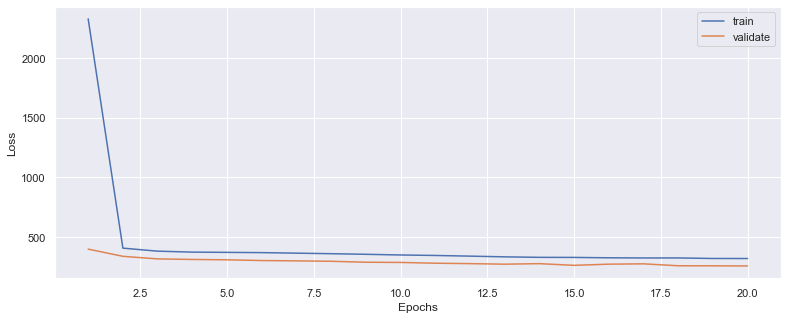

In [20]:
plot_loss(history)

In [21]:
# predict and evaluate
y_hat_train = model.predict(X_train_smooth[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train')

train set RMSE:17.433590186466215, R2:0.8249868754417847


In [22]:
# only run the test set once you're happy with the preprocessing
y_hat_test = model.predict(X_test_smooth[train_cols])
evaluate(y_test, y_hat_test)

test set RMSE:18.681100442307972, R2:0.7979097473627429


Unfortunately smoothing the data for FD001 makes the predictions worse, but that's besides the point. The point is, you can go back and forth between preprocessing and training, trying different settings and when you want to use a previous setting you can be assured the results are the same.

The initial NN developed here (without smoothing or feature selection) already has an RMSE of 18.50 on the FD001 dataset. A whopping 42% improvement over the baseline model and a big improvement over the previous best, which was a SVR with an RMSE of 20.54 (and an overall improvent of 35.7% on the baseline model). In my next article, we'll delve into FD002 in which the turbofan engines run on different operating conditions and the exponential smoothing does have a beneficial effect.